In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D, art3d
import seaborn as sns
from scipy import stats
import laplacejumps as lj
import statsmodels.api as sm
from pandas_datareader import data as pd_data
from statsmodels.tsa import api as tsa
from linearmodels import iv

In [7]:
paper = False

In [8]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')

if paper:
    presentation_fontsize = 16
else:
    presentation_fontsize = 22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})
# mpl.rc('text',usetex=True)
# mpl.rc('text.latex', preamble=r'\usepackage{color}')


In [9]:
pgf_with_custom_preamble = {
    "font.family": "serif", # use serif/main font for text elements
    "text.usetex": True,    # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.preamble": [
         r"\usepackage{unicode-math}",  # unicode math setup
         r'\usepackage{xcolor}'     
         ]
}

In [10]:
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
# mpl.rcParams.update(pgf_with_custom_preamble)

## Load Data

In [11]:
with pd.HDFStore('../results/spy_daily_estimates_2003-2017_1000_1sec.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est']
    
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['jump_prop'] = discrete_vol['jumps'] / discrete_vol['quad']
log_vol = discrete_vol.transform(np.log).dropna()

In [12]:
daily_rtn_data = pd.read_csv('../results/spy_daily_rtn_2003-2017_with_overnight.csv', index_col=0,
                         parse_dates=True).rename(columns={'log_price':'daily_rtn'}).daily_rtn
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})
daily_rtn = 252 * (daily_rtn_data - treasury_yield.T).T.rename(columns={'log_yield':'daily_rtn'}).dropna()

In [13]:
fed_announcement_dates = pd.read_hdf('../results/fomc_times.hdf', 'table')
dates = pd.DataFrame(np.ones((fed_announcement_dates.size,1)), 
                     index=fed_announcement_dates['FOMC_times']).resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})

In [14]:
data = pd.concat([dates, discrete_vol, daily_rtn], axis=1).dropna()

## Set Hyperparameters

In [15]:
color_intercept = 100 * np.asscalar(data.daily_rtn.quantile([.06]).abs())
color_scale = 100 * (np.asscalar(data.daily_rtn.quantile([.10]).abs()) 
                     + np.asscalar(data.daily_rtn.quantile([.90]).abs()))

In [16]:
quantiles = [0.5]
n_levels = 8

In [17]:
data.sort_values(by='jump_prop', ascending=False).head()

fomc_dates  absolute   diffusion       jumps        quad  \
2012-12-24         0.0    0.0036  4.4980e-06  5.2945e-05  5.7443e-05   
2013-12-24         0.0    0.0019  8.7662e-07  7.8376e-06  8.7143e-06   
2004-09-02         0.0    0.0033  3.1700e-06  2.2013e-05  2.5183e-05   
2013-09-18         1.0    0.0040  8.5305e-06  5.5888e-05  6.4418e-05   
2010-05-06         0.0    0.0247  4.1495e-04  2.6953e-03  3.1103e-03   

            jump_prop  daily_rtn  
2012-12-24     0.9217    -1.0203  
2013-12-24     0.8994     1.1630  
2004-09-02     0.8741     2.7854  
2013-09-18     0.8676     2.9984  
2010-05-06     0.8666    -8.5351

In [18]:
pd.concat([data.jump_prop, data.fomc_dates], axis=1).corr()

jump_prop  fomc_dates
jump_prop      1.0000      0.0475
fomc_dates     0.0475      1.0000

## Jump Proportion Plots

In [19]:
start = mpl.dates.date2num(pd.to_datetime('2007-12'))
recession_length = mpl.dates.date2num(pd.to_datetime('2009-06')) - start

In [200]:
prop_fig, prop_ax = mpl.pyplot.subplots()
if paper:
    prop_ax.plot(data.jump_prop, color='red', alpha=.75,
             label=r'$\frac{\gamma_t^2}{\sigma_t^2 + \gamma_t^2}$')
else:
    prop_ax.plot(data.jump_prop, color='red', alpha=.75, 
                 label='\n')
    

prop_ax.plot(data.jump_prop.rolling('30D').mean(), label='30 Day Rolling\n Average', color='green',
             linestyle='--')
prop_ax.set_ylim([0,1])
prop_ax.axhline(data.jump_prop.mean(), color='black', label='Mean'.format(data.jump_prop.mean()))

patch = mpl.patches.Rectangle(xy=(start, 0), width=recession_length, height=1, color='grey', alpha=.5)
                              
prop_ax.add_patch(patch)
handles, labels = prop_ax.get_legend_handles_labels()
prop_ax.legend(handles, labels, bbox_to_anchor=(1.0,.2),loc='center right')

if paper:
    filename = '../doc/figures/jump_proportion_paper.tmp.pdf'
else:
    filename = '../doc/figures/jump_proportion.tmp.pdf'
    
prop_fig.savefig(filename, transparent=True, bbox_inches='tight', pad_inches=0, frameon=False)

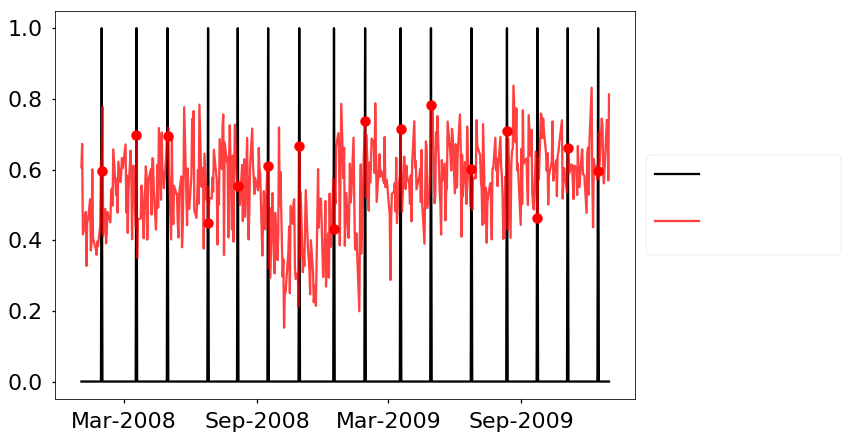

In [21]:
fomc_jump_fig, fomc_jump_ax = mpl.pyplot.subplots()

fomc_jump_ax.plot(data.fomc_dates['2008':'2009'], color='black', label='$1\{FOMC\}_t$')
fomc_jump_ax.plot(data.jump_prop['2008':'2009'], color='red', alpha=.75,
                  label=r'$\frac{\gamma^2_t}{\sigma^2_t + \gamma^2_t}$')
jump_days = data.jump_prop['2008':'2009'].loc[data.fomc_dates['2008':'2009'] == 1]
fomc_jump_ax.scatter(x=jump_days.index, y=jump_days, s=100, color='red', zorder=10, label=None)
fomc_jump_ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=6))
fomc_jump_ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%b-%Y'))
legend = fomc_jump_ax.legend(bbox_to_anchor=(1,.5), loc='center left')

if not paper:
    for text in legend.get_texts():
        text.set_color("White")
    filename = '../doc/figures/fomc_v_jump_proportion.tmp.pdf'
else:
    filename = '../doc/figures/fomc_v_jump_proportion_paper.tmp.pdf'
    
    
fomc_jump_fig.savefig(filename, bbox_inches='tight', frameon=False, pad_inches=0, transparent=True)

In [22]:
data.head()

fomc_dates  absolute   diffusion       jumps        quad  \
2003-01-03         0.0    0.0081  7.1296e-05  5.1311e-05  1.2261e-04   
2003-01-06         0.0    0.0061  3.3123e-05  3.9098e-05  7.2221e-05   
2003-01-07         0.0    0.0087  7.0698e-05  5.9916e-05  1.3061e-04   
2003-01-08         0.0    0.0074  3.9652e-05  6.1865e-05  1.0152e-04   
2003-01-09         0.0    0.0062  2.2008e-05  5.6997e-05  7.9005e-05   

            jump_prop  daily_rtn  
2003-01-03     0.4185    -0.1317  
2003-01-06     0.5414     5.4954  
2003-01-07     0.4587    -1.5315  
2003-01-08     0.6094    -3.7850  
2003-01-09     0.7214     4.8963

In [23]:
iv.IVGMM.from_formula("jump_prop ~ 1 + fomc_dates", data=data.dropna()).fit(cov_type='kernel', center=True, 
                                                                     optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              jump_prop   R-squared:                      0.0023
Estimator:                     IV-GMM   Adj. R-squared:                 0.0020
No. Observations:                3678   F-statistic:                    7.3510
Date:                Thu, Dec 20 2018   P-value (F-stat)                0.0067
Time:                        11:35:33   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.5634     0.0048     116.41     0.0000      0.5540      0.5729
fomc_dates     0.0316     0.0116     2.7113     0.0067      0.0087      0.0544
==============================================================================
IVGMMResults, id: 0x7f692c371c18

In [24]:
data.columns

Index(['fomc_dates', 'absolute', 'diffusion', 'jumps', 'quad', 'jump_prop',
       'daily_rtn'],
      dtype='object')

In [25]:
iv.IVGMM.from_formula("daily_rtn ~ 1 + [jump_prop ~ fomc_dates]",  data=data.dropna()).fit(
    cov_type='kernel', center=True, optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.9923
Estimator:                     IV-GMM   Adj. R-squared:                -0.9928
No. Observations:                3678   F-statistic:                    4.6917
Date:                Thu, Dec 20 2018   P-value (F-stat)                0.0303
Time:                        11:35:33   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -15.694     7.2708    -2.1585     0.0309     -29.945     -1.4437
jump_prop      27.872     12.868     2.1660     0.0303      2.6518      53.093
==============================================================================

Endogenous: jump_prop
Instruments: fomc_dates
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 28
IVGMMResults, id: 0x7f692c2e7940

In [26]:
iv.IVGMM.from_formula("daily_rtn ~ 1 + [jumps ~ fomc_dates]",  data=data.dropna()).fit(
    cov_type='kernel', center=True, optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.9898
Estimator:                     IV-GMM   Adj. R-squared:                -0.9903
No. Observations:                3678   F-statistic:                    6.0985
Date:                Thu, Dec 20 2018   P-value (F-stat)                0.0135
Time:                        11:35:34   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -1.1604     0.4718    -2.4594     0.0139     -2.0852     -0.2357
jumps       2.729e+04  1.105e+04     2.4695     0.0135      5631.4   4.895e+04
==============================================================================

Endogenous: jumps
Instruments: fomc_dates
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 43
IVGMMResults, id: 0x7f692c3304a8

In [27]:
data.head()

fomc_dates  absolute   diffusion       jumps        quad  \
2003-01-03         0.0    0.0081  7.1296e-05  5.1311e-05  1.2261e-04   
2003-01-06         0.0    0.0061  3.3123e-05  3.9098e-05  7.2221e-05   
2003-01-07         0.0    0.0087  7.0698e-05  5.9916e-05  1.3061e-04   
2003-01-08         0.0    0.0074  3.9652e-05  6.1865e-05  1.0152e-04   
2003-01-09         0.0    0.0062  2.2008e-05  5.6997e-05  7.9005e-05   

            jump_prop  daily_rtn  
2003-01-03     0.4185    -0.1317  
2003-01-06     0.5414     5.4954  
2003-01-07     0.4587    -1.5315  
2003-01-08     0.6094    -3.7850  
2003-01-09     0.7214     4.8963

In [28]:
iv.IVGMM.from_formula("daily_rtn ~ 1 +  + [jumps ~ fomc_dates]",  data=data.dropna()).fit(
    cov_type='kernel', center=True, optimal_bw=True)

PatsyError: expected a noun, but instead the expression ended
    0 + 1 +
          ^

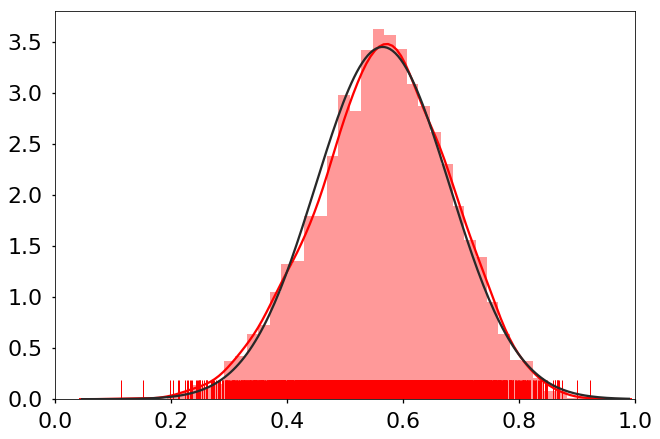

In [33]:
jump_prop_dens_fig, jump_prop_dens_ax = mpl.pyplot.subplots()
sns.distplot(data.jump_prop.values, rug=True, fit=stats.norm, ax=jump_prop_dens_ax, color='red')
jump_prop_dens_ax.set_xlim([0,1])
jump_prop_dens_fig.savefig('../doc/figures/jump_proportion_density.tmp.pdf', bbox_tight=True, frameon=False,
                           pad_inches=0, transparent=True)

In [34]:
data.describe()

fomc_dates   absolute   diffusion       jumps        quad  jump_prop  \
count   3678.0000  3678.0000  3.6780e+03  3.6780e+03  3.6780e+03  3678.0000   
mean       0.0313     0.0056  4.4689e-05  4.3911e-05  8.8599e-05     0.5644   
std        0.1741     0.0041  1.5203e-04  9.1199e-05  2.2805e-04     0.1155   
min        0.0000     0.0009  6.1561e-07  1.0652e-06  1.9422e-06     0.1138   
25%        0.0000     0.0034  8.4873e-06  1.2720e-05  2.1903e-05     0.4898   
50%        0.0000     0.0044  1.6043e-05  2.1777e-05  3.8244e-05     0.5681   
75%        0.0000     0.0064  3.5654e-05  4.3322e-05  7.9289e-05     0.6445   
max        1.0000     0.0615  4.9792e-03  2.6953e-03  6.6434e-03     0.9217   

       daily_rtn  
count  3678.0000  
mean      0.0380  
std       2.8543  
min     -24.2947  
25%      -1.0834  
50%       0.1322  
75%       1.3457  
max      25.5391

In [35]:
data.sort_values(by='quad', ascending=False).head()

fomc_dates  absolute  diffusion   jumps    quad  jump_prop  \
2008-10-10         0.0    0.0615     0.0050  0.0017  0.0066     0.2505   
2010-05-06         0.0    0.0247     0.0004  0.0027  0.0031     0.8666   
2008-10-16         0.0    0.0449     0.0023  0.0008  0.0031     0.2499   
2008-11-20         0.0    0.0425     0.0021  0.0008  0.0029     0.2719   
2008-10-09         0.0    0.0362     0.0022  0.0007  0.0029     0.2477   

            daily_rtn  
2008-10-10    -3.3454  
2010-05-06    -8.5351  
2008-10-16    10.1935  
2008-11-20   -17.6049  
2008-10-09   -17.7541

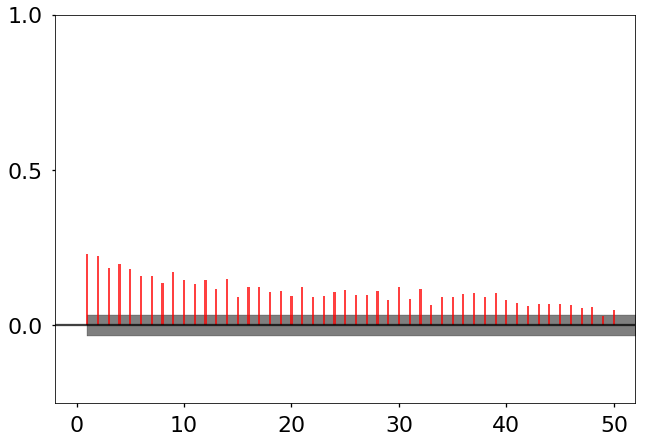

In [36]:
prop_autocorr_fig, prop_autocorr_ax = mpl.pyplot.subplots()
prop_acf = tsa.acf(data.jump_prop.dropna(), nlags=50, unbiased=True)
prop_autocorr_ax.bar(np.arange(1,prop_acf.size), prop_acf[1:], width=0.2, color='red', alpha=.75)
prop_autocorr_ax.fill_between(x=np.arange(1, prop_acf.size+5), y1=1.96 * data.jump_prop.size**(-.5), 
                              color='black',
                              alpha=.5, y2=-1.96 * data.jump_prop.size**(-.5))
prop_autocorr_ax.axhline(0,color='black', alpha=.75)
prop_autocorr_ax.set_ylim([-0.25, 1])
prop_autocorr_ax.set_xlim([-2, 52])
prop_autocorr_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 0.5, 1]))
prop_autocorr_fig.savefig('../doc/figures//jump_prop_autocorrelation_function.tmp.pdf', bbox_tight=True, frameon=False,
                           pad_inches=0, transparent=True)

In [37]:
quad_data = data.quad.transform(lambda x: np.sqrt(x - x.min()) / np.sqrt(x.max())).loc['2008-07':'2008-12']
prop_data = data.jump_prop.transform(lambda x: np.sqrt(x - x.min()) / np.sqrt(x.max())).loc['2008-07':'2008-12']

jump_prop_fig, jump_prop_ax = mpl.pyplot.subplots()
jump_prop_fig.set_size_inches((10, 6))
# vol_ax = jump_prop_ax.twinx()
# vol_ax.set_ylim([0, 0.1])
jump_prop_ax.set_xlim([data['2008-07':'2008-12'].index[0], data['2008-07':'2008-12'].index[-1]])

vol_data = ((data['2008-07':'2008-12'].quad.apply(np.sqrt) - data.quad.apply(np.sqrt).min()) /
            data.quad.apply(np.sqrt).max())

jump_prop_ax.fill_between(quad_data.index, quad_data, color='purple', alpha=.25)
#                           label=r'$\sqrt{\textcolor{blue}{\sigma_t^2} + \textcolor{red}{\gamma_t^2}}$')

jump_prop_ax.set_ylim([0,1])

jump_prop_ax.plot(prop_data, color='red', zorder=0)
#                   label=r"$\frac{\textcolor{red}{\gamma_t^2}}{\textcolor{blue}{\sigma_t^2} + \textcolor{red}{\gamma_t^2}}$")
fomc_dates = dates['2008-07':'2008-12'].query('fomc_dates == 1')
fomc_name = 'FOMC'

jump_prop_ax.scatter(x=fomc_dates.index, y=prop_data.loc[fomc_dates.index], s=200, label=fomc_name,
                    color='green')

fomc_emergency_date = pd.to_datetime('2008-10-08')
jump_prop_ax.scatter(x=fomc_emergency_date, y=prop_data.loc[fomc_emergency_date], s=200,
                     color='lawngreen', label='FOMC Emergency')
jump_days = prop_data.sort_values(ascending=False).iloc[:4]

if paper:
    jump_prop_ax.scatter(x=jump_days.index, y=jump_days, s=200, color='red', label="Peak")

jump_prop_ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator())
jump_prop_ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b"))
# vol_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 0.025, 0.05, 0.075, 0.1]))
# vol_ax.yaxis.set_label("umm")
jump_prop_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 0.5,  1]))
jump_prop_ax.yaxis.set_ticklabels(['Min', 'Center', 'Max'])
# jump_prop_ax.yaxis.set_major_locator(mpl.ticker.La([0, 0.25, 0.5, 0.75, 1]))
# vol_ax_handles, vol_ax_labels = vol_ax.get_legend_handles_labels()
prop_ax_handles, prop_ax_labels = jump_prop_ax.get_legend_handles_labels()
legend = jump_prop_ax.legend(prop_ax_handles, prop_ax_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')
legend.get_frame().set_alpha(0)

    
if not paper:    
    jump_prop_ax.scatter(x=jump_days.index, y=jump_days, s=200, color='red')

if paper:
    jump_prop_fig.savefig(fname='../doc/figures/jump_proportion_fall_2008_paper.tmp.pdf', transparent=True, 
              bbox_inches='tight', pad_inches=0, frameon=False)
else:
    jump_prop_fig.savefig(fname='../doc/figures/jump_proportion_fall_2008.tmp.pdf', transparent=True, 
              bbox_inches='tight', pad_inches=0, frameon=False)

In [38]:
dates['2008-07':'2008-12'].query('fomc_dates == 1')

fomc_dates
FOMC_times            
2008-08-05         1.0
2008-09-16         1.0
2008-10-29         1.0
2008-12-16         1.0

## 3D Plots

In [39]:
data_for_plot = data.copy()
data_for_plot['root_quad'] = data_for_plot['quad'].apply(np.sqrt)
quad_x = np.log(data_for_plot.root_quad.quantile([0] + quantiles + [1])**2)
jump_prop_x = data_for_plot.jump_prop.quantile([0] + quantiles + [1])
z_values = 100 * lj.bin_data(data=data_for_plot, quantiles=quantiles, endog='daily_rtn', 
                               exog=['jump_prop', 'root_quad'])
sorted_z_values = z_values.stack().reset_index().rename(columns={0:'rtn'}).sort_values(by='rtn')

verts = []
for _, val in sorted_z_values.iterrows():
    verts.append([(quad_x.loc[val.root_quad], jump_prop_x.loc[:val.jump_prop].iloc[-2], val.rtn),
                 (quad_x.loc[val.root_quad], jump_prop_x.loc[val.jump_prop], val.rtn),
                  (quad_x.loc[:val.root_quad].iloc[-2], jump_prop_x.loc[val.jump_prop], val.rtn),
                  (quad_x.loc[:val.root_quad].iloc[-2], jump_prop_x.loc[:val.jump_prop].iloc[-2], val.rtn)])

verts_arr = np.asarray(verts)
twoD_verts = verts_arr[:,:,:-1]

colors = mpl.cm.cubehelix((sorted_z_values.rtn + color_intercept) / 3)

In [40]:
sorted_z_values

root_quad  jump_prop      rtn
2        1.0        0.5 -65.3759
3        1.0        1.0  10.8754
0        0.5        0.5  35.2102
1        0.5        1.0  45.0635

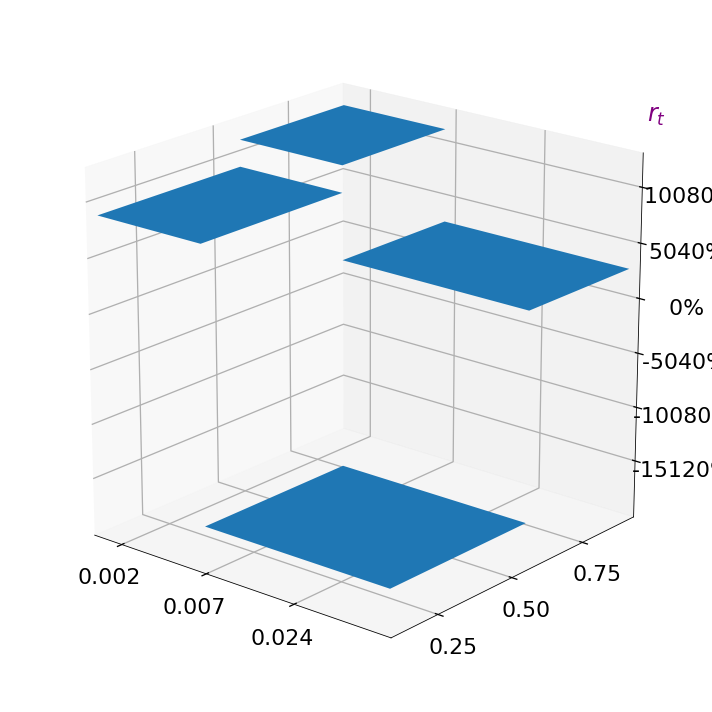

In [41]:
fig_3d = mpl.pyplot.figure()
fig_3d.set_size_inches((10,10))
ax_3d = fig_3d.add_subplot(111, projection='3d')

ax_3d.add_collection3d(art3d.Poly3DCollection(verts_arr))

# ax_3d.set_ylabel('$\gamma^2_t / (\sigma^2_t + \gamma^2_t)$')
# ax_3d.set_xlabel('$\sqrt{\sigma^2_t + \gamma^2_t}$')

ax_3d.set_ylim([np.asscalar(discrete_vol.jump_prop.min()), np.asscalar(discrete_vol.jump_prop.max())])
ax_3d.set_xlim([np.asscalar(quad_x.min()), np.asscalar(quad_x.max())])
ax_3d.set_zlim([1.2 * np.asscalar(sorted_z_values.rtn.min()), 1.1 * np.asscalar(sorted_z_values.rtn.max())])

ax_3d.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, y: '{:.3f}'.format(np.exp(.5 * x))))
ax_3d.zaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, y: '      {:.0f}%'.format(252 * x)))
ax_3d.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
ax_3d.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
ax_3d.xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
ax_3d.annotate(s='$r_t$',xy=(.92,.84), fontsize=24, xycoords=ax_3d.transAxes, color='purple')

ax_3d.xaxis.labelpad=30
ax_3d.yaxis.labelpad=30
ax_3d.zaxis.labelpad=20
ax_3d.elev -= 10
ax_3d.azim += 10
mpl.pyplot.tight_layout()

fig_3d.savefig(fname='../doc/figures/3d_binned_daily_rtn.tmp.pdf', transparent=True, bbox_inches='tight', 
               pad_inches=.3, frameon=False)

In [42]:
sorted_z_values * 252

root_quad  jump_prop         rtn
2      252.0      126.0 -16474.7241
3      252.0      252.0   2740.6034
0      126.0      126.0   8872.9793
1      126.0      252.0  11355.9898

In [43]:
jump_prop_median = data.median().jump_prop
print('Jump Prop without FOMC\n' + str(data.query('jump_prop >= @jump_prop_median').query('fomc_dates == 0').mean()))
print('\n\nFOMC days\n' + str(data.query('fomc_dates == 1').mean()))

Jump Prop without FOMC
fomc_dates    0.0000e+00
absolute      4.7115e-03
diffusion     2.0035e-05
jumps         3.7652e-05
quad          5.7687e-05
jump_prop     6.5558e-01
daily_rtn     2.7863e-01
dtype: float64


FOMC days
fomc_dates    1.0000e+00
absolute      6.1583e-03
diffusion     5.1369e-05
jumps         7.5135e-05
quad          1.2650e-04
jump_prop     5.9501e-01
daily_rtn     8.9016e-01
dtype: float64


In [44]:
data.query('fomc_dates == 1').mean()

fomc_dates    1.0000e+00
absolute      6.1583e-03
diffusion     5.1369e-05
jumps         7.5135e-05
quad          1.2650e-04
jump_prop     5.9501e-01
daily_rtn     8.9016e-01
dtype: float64

In [45]:
data.query('jump_prop > @jump_prop_median').mean()

fomc_dates    3.6433e-02
absolute      4.7627e-03
diffusion     2.0913e-05
jumps         3.9621e-05
quad          6.0534e-05
jump_prop     6.5647e-01
daily_rtn     3.0693e-01
dtype: float64

In [46]:
data.query('jump_prop >= @jump_prop_median').query('fomc_dates == 0').mean()

fomc_dates    0.0000e+00
absolute      4.7115e-03
diffusion     2.0035e-05
jumps         3.7652e-05
quad          5.7687e-05
jump_prop     6.5558e-01
daily_rtn     2.7863e-01
dtype: float64

In [47]:
stats.describe(data.query('jump_prop < @jump_prop_median').daily_rtn * 100)

DescribeResult(nobs=1839, minmax=(-2429.4684762167476, 2553.907183644293), mean=-23.09580527378697, variance=109323.5844914002, skewness=-0.5742945316715026, kurtosis=8.501568122911786)

In [48]:
data.corr()

fomc_dates  absolute  diffusion   jumps    quad  jump_prop  \
fomc_dates      1.0000    0.0260     0.0079  0.0615  0.0299     0.0475   
absolute        0.0260    1.0000     0.8227  0.8311  0.8808    -0.3211   
diffusion       0.0079    0.8227     1.0000  0.7420  0.9634    -0.2880   
jumps           0.0615    0.8311     0.7420  1.0000  0.8946    -0.0989   
quad            0.0299    0.8808     0.9634  0.8946  1.0000    -0.2315   
jump_prop       0.0475   -0.3211    -0.2880 -0.0989 -0.2315     1.0000   
daily_rtn       0.0536   -0.1637    -0.1144 -0.1315 -0.1289     0.1243   

            daily_rtn  
fomc_dates     0.0536  
absolute      -0.1637  
diffusion     -0.1144  
jumps         -0.1315  
quad          -0.1289  
jump_prop      0.1243  
daily_rtn      1.0000

In [49]:
prop_and_vol_model = sm.WLS.from_formula('(daily_rtn - log_yield) ~ jump_prop * quad.apply(np.log)', weights=data.quad**(-1), data=data).fit()
prop_and_vol_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Weighted least squares
==============================================================================
Model:                   WLS                 Adj. R-squared:        0.029     
Dependent Variable:      daily_rtn           AIC:                   15657.7880
Date:                    2018-12-20 11:38    BIC:                   15682.6285
No. Observations:        3678                Log-Likelihood:        -7824.9   
Df Model:                3                   F-statistic:           37.25     
Df Residuals:            3674                Prob (F-statistic):    1.05e-23  
R-squared:               0.030               Scale:                 94739.    
------------------------------------------------------------------------------
                              Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------------------
Intercept                    -12.0713   1.7625 -6.8491 0.0000 -15.5268 -8.6158
jump_prop                     16.9612   3.0915  5.4864 0.0000  10.9000 23.0223
quad.apply(np.log)            -1.0938   0.1617 -6.7630 0.0000  -1.4109 -0.7767
jump_prop:quad.apply(np.log)   1.4749   0.2831  5.2103 0.0000   0.9199  2.0299
------------------------------------------------------------------------------
Omnibus:                   78.988           Durbin-Watson:              2.096 
Prob(Omnibus):             0.000            Jarque-Bera (JB):           86.781
Skew:                      0.332            Prob(JB):                   0.000 
Kurtosis:                  3.353            Condition No.:              1672  
==============================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

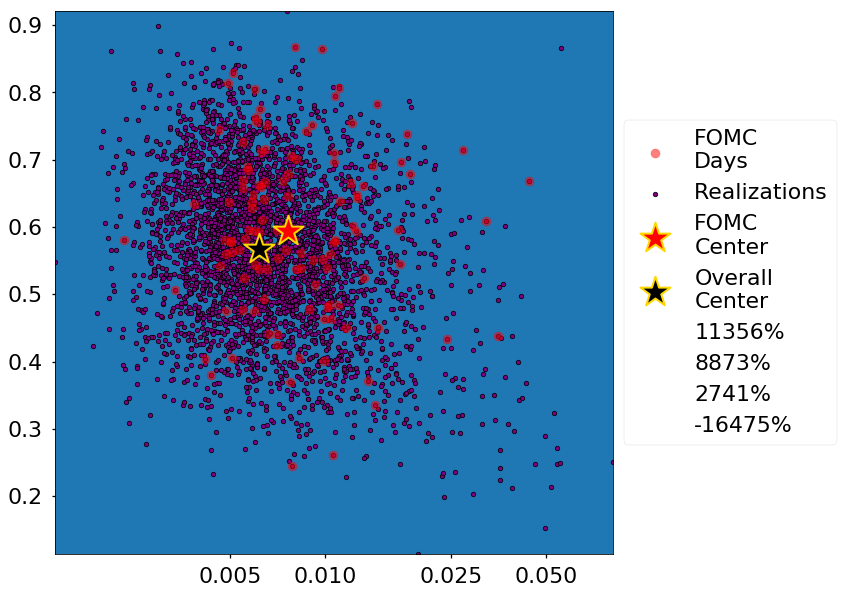

In [50]:
fig_2d, ax_2d = mpl.pyplot.subplots()
fig_2d.set_size_inches((10,10))
ax_2d.add_collection(art3d.PolyCollection(twoD_verts))

announcement_data = data_for_plot.query('fomc_dates == 1')
ax_2d.scatter(y=announcement_data.jump_prop, x=np.log(announcement_data.root_quad**2), color='red', zorder=10,
              alpha=.5, label='FOMC\nDays')
ax_2d.scatter(y=data_for_plot.jump_prop, x=np.log(data_for_plot.root_quad**2), facecolor='purple',
              edgecolor='black', alpha=1, linewidth=.75, s=20, label='Realizations')
ax_2d.scatter(y=announcement_data.jump_prop.median(), x=np.log(announcement_data.root_quad.median()**2), 
              facecolor='red', zorder=10, marker='*', alpha=1, s=1000, label='FOMC\nCenter', edgecolor='gold', 
              linewidth=2)
ax_2d.scatter(y=jump_prop_x.median(), x=quad_x.median(), facecolor='black', edgecolor='gold', linewidth=2,
              zorder=10, marker='*', alpha=1, s=1000, label='Overall\nCenter')
# ax_2d.set_ylabel('$\gamma^2_t / (\sigma^2_t + \gamma^2_t)$')
# ax_2d.set_xlabel('$\sqrt{\sigma^2_t + \gamma^2_t}$')
ax_2d.set_ylim([np.asscalar(jump_prop_x.min()), np.asscalar(jump_prop_x.max())])
ax_2d.set_xlim([np.asscalar(quad_x.min()), np.asscalar(quad_x.max())])
ax_2d.xaxis.set_major_locator(mpl.ticker.FixedLocator(locs=2 * np.log([0.005, 0.01, 0.025, 0.05, .09])))
ax_2d.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, y: '{:0.3f}'.format(np.exp(.5 * x))))


handles2, labels2 = list(zip(*[(mpl.patches.Patch(color=color), '{:.0f}%'.format(252 * label))
                      for color, label in list(zip(colors,sorted_z_values.rtn.values))[::-1]]))

handles1, labels1 = ax_2d.get_legend_handles_labels()
ax_2d.legend(handles1 + list(handles2), labels1 + list(labels2), bbox_to_anchor=(1,.5), loc='center left')
fig_2d.savefig(fname='../doc/figures/2d_binned_daily_rtn.tmp.pdf', transparent=True, bbox_inches='tight', 
               pad_inches=0, frameon=False)

In [51]:
announce_high_jump_prop = announcement_data.jump_prop > data_for_plot.jump_prop.median()
announce_high_vol = announcement_data.quad > data_for_plot.quad.median()

In [52]:
np.mean(announce_high_jump_prop & announce_high_vol)

0.3652173913043478

In [53]:
announcement_data.mean()

fomc_dates    1.0000e+00
absolute      6.1583e-03
diffusion     5.1369e-05
jumps         7.5135e-05
quad          1.2650e-04
jump_prop     5.9501e-01
daily_rtn     8.9016e-01
root_quad     9.4069e-03
dtype: float64

In [54]:
sorted_z_values

root_quad  jump_prop      rtn
2        1.0        0.5 -65.3759
3        1.0        1.0  10.8754
0        0.5        0.5  35.2102
1        0.5        1.0  45.0635

In [55]:
rtn_list = []
for row in sorted_z_values.itertuples():
    quad_pct = data_for_plot.root_quad.quantile(row.root_quad)**2
    prop_pct = data_for_plot.jump_prop.quantile(row.jump_prop)
    fraction = (announcement_data.query('quad >= @quad_pct').query('jump_prop >= @prop_pct').shape[0] 
                / announcement_data.shape[0])
    
    rtn_list.append(fraction * row.rtn)
print(np.sum(fraction))

0.0


In [56]:
np.mean(announce_high_vol & (1-announce_high_jump_prop))

0.30434782608695654

In [57]:
announcement_data.mean().daily_rtn

0.8901630335453533

In [58]:
jump_prop_median = data_for_plot.jump_prop.median()
data_for_plot.query('fomc_dates==0').query('jump_prop < @jump_prop_median').mean()

fomc_dates    0.0000e+00
absolute      6.3801e-03
diffusion     6.8652e-05
jumps         4.8098e-05
quad          1.1675e-04
jump_prop     4.7230e-01
daily_rtn    -2.5482e-01
root_quad     8.6105e-03
dtype: float64

In [59]:
data_for_plot.query('fomc_dates==0').mean()

fomc_dates    0.0000e+00
absolute      5.5503e-03
diffusion     4.4473e-05
jumps         4.2903e-05
quad          8.7376e-05
jump_prop     5.6345e-01
daily_rtn     1.0481e-02
root_quad     7.6238e-03
dtype: float64

## Contour Plot

In [60]:
data.head()

fomc_dates  absolute   diffusion       jumps        quad  \
2003-01-03         0.0    0.0081  7.1296e-05  5.1311e-05  1.2261e-04   
2003-01-06         0.0    0.0061  3.3123e-05  3.9098e-05  7.2221e-05   
2003-01-07         0.0    0.0087  7.0698e-05  5.9916e-05  1.3061e-04   
2003-01-08         0.0    0.0074  3.9652e-05  6.1865e-05  1.0152e-04   
2003-01-09         0.0    0.0062  2.2008e-05  5.6997e-05  7.9005e-05   

            jump_prop  daily_rtn  
2003-01-03     0.4185    -0.1317  
2003-01-06     0.5414     5.4954  
2003-01-07     0.4587    -1.5315  
2003-01-08     0.6094    -3.7850  
2003-01-09     0.7214     4.8963

In [61]:
contour_plot_data = data.copy()
vol_columns = ['absolute', 'diffusion', 'jumps']
contour_plot_data.loc[:, vol_columns] = contour_plot_data.loc[:, vol_columns].transform(np.log)

In [62]:
def demean_prop(x, undo=False):
    if not undo:
        return x - contour_plot_data.jump_prop.mean()
    else:
        return x + contour_plot_data.jump_prop.mean()

In [63]:
def demean_quad(x, undo=False):
    if not undo:
        return x - contour_plot_data.quad.apply(np.log).mean()
    else:
        return x + contour_plot_data.quad.apply(np.log).mean()

In [64]:
contour_plot_data['log_quad'] = data_for_plot['quad'].transform(demean_quad)
contour_plot_data['prop'] = contour_plot_data['jump_prop'].transform(demean_prop)
announcement_data = contour_plot_data.query('fomc_dates == 1')


In [65]:
contour_plot_data.head()

fomc_dates  absolute  diffusion    jumps        quad  jump_prop  \
2003-01-03         0.0   -4.8204    -9.5487  -9.8776  1.2261e-04     0.4185   
2003-01-06         0.0   -5.0934   -10.3153 -10.1494  7.2221e-05     0.5414   
2003-01-07         0.0   -4.7491    -9.5571  -9.7226  1.3061e-04     0.4587   
2003-01-08         0.0   -4.9081   -10.1354  -9.6905  1.0152e-04     0.6094   
2003-01-09         0.0   -5.0847   -10.7241  -9.7725  7.9005e-05     0.7214   

            daily_rtn  log_quad    prop  
2003-01-03    -0.1317   10.0408 -0.1459  
2003-01-06     5.4954   10.0408 -0.0231  
2003-01-07    -1.5315   10.0408 -0.1057  
2003-01-08    -3.7850   10.0408  0.0450  
2003-01-09     4.8963   10.0408  0.1570

In [66]:
np.atleast_2d(np.linspace(1,1,100).T).T.shape

(100, 1)

In [67]:
contour_plot_data.head()

fomc_dates  absolute  diffusion    jumps        quad  jump_prop  \
2003-01-03         0.0   -4.8204    -9.5487  -9.8776  1.2261e-04     0.4185   
2003-01-06         0.0   -5.0934   -10.3153 -10.1494  7.2221e-05     0.5414   
2003-01-07         0.0   -4.7491    -9.5571  -9.7226  1.3061e-04     0.4587   
2003-01-08         0.0   -4.9081   -10.1354  -9.6905  1.0152e-04     0.6094   
2003-01-09         0.0   -5.0847   -10.7241  -9.7725  7.9005e-05     0.7214   

            daily_rtn  log_quad    prop  
2003-01-03    -0.1317   10.0408 -0.1459  
2003-01-06     5.4954   10.0408 -0.0231  
2003-01-07    -1.5315   10.0408 -0.1057  
2003-01-08    -3.7850   10.0408  0.0450  
2003-01-09     4.8963   10.0408  0.1570

In [68]:
regressors, regressor_indices = lj.get_minimum_ic_regressors(contour_plot_data.daily_rtn, 
                                                             contour_plot_data[['log_quad', 'prop']], 
                                                             degree=5,
                                                             weights=contour_plot_data.quad**(-1),
                                                             criterion='aic')

contour_plot_model = sm.WLS(endog=contour_plot_data.daily_rtn, exog=regressors,
                            weights=contour_plot_data.quad**(-1)).fit()
levels = contour_plot_data.daily_rtn.quantile(np.linspace(0,1,n_levels))
X, Y = np.meshgrid(np.linspace(contour_plot_data.log_quad.min(), contour_plot_data.log_quad.max(), 100), 
                    np.linspace(contour_plot_data.prop.min(),contour_plot_data.prop.max(),100))


In [69]:
graphing_regressors = lj.create_polynomial_regressors(np.column_stack([X.ravel(), Y.ravel()]) , regressor_indices)
Z = contour_plot_model.predict(exog=graphing_regressors).reshape((100,100))

In [70]:
regressor_indices

array([[0, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 1]])

In [71]:
contour_plot_model.pvalues

const    0.0002
x1       0.0002
x2       0.0867
x3       0.0002
x4       0.0867
dtype: float64

In [72]:
contour_plot_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Weighted least squares
===============================================================================
Model:                  WLS                  Adj. R-squared:         0.022     
Dependent Variable:     daily_rtn            AIC:                    15684.7220
Date:                   2018-12-20 11:38     BIC:                    15715.7726
No. Observations:       3678                 Log-Likelihood:         -7837.4   
Df Model:               4                    F-statistic:            21.53     
Df Residuals:           3673                 Prob (F-statistic):     1.40e-17  
R-squared:              0.023                Scale:                  95409.    
-------------------------------------------------------------------------------
          Coef.         Std.Err.      t    P>|t|      [0.025         0.975]    
-------------------------------------------------------------------------------
const 209489665.5137 56489235.7000  3.7085 0.0002  98736301.6463 320243029.3810
x1    -41722066.9980 11251720.3708 -3.7081 0.0002 -63782303.1637 -19661830.8323
x2       -81193.5798    47377.8490 -1.7137 0.0867   -174083.0672     11695.9076
x3      2077346.9159   560289.0986  3.7076 0.0002    978838.4720   3175855.3598
x4         8086.5085     4718.5680  1.7138 0.0867     -1164.7635     17337.7804
-------------------------------------------------------------------------------
Omnibus:                73.114          Durbin-Watson:             2.106       
Prob(Omnibus):          0.000           Jarque-Bera (JB):          79.352      
Skew:                   0.322           Prob(JB):                  0.000       
Kurtosis:               3.320           Condition No.:             215760225952
===============================================================================
* The condition number is large (2e+11). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [73]:
contour_labels = np.asarray([np.mean(contour_plot_data.daily_rtn[np.digitize(contour_plot_data.daily_rtn, 
                                                                     bins=levels.iloc[1:]) == val])
                     for val in range(len(levels) -1)])
contour_colors = mpl.cm.cubehelix((100 * contour_labels + color_intercept) / color_scale)
contour_formatted_labels = ['{:.0f}%'.format(100 * 252 * val) for val in contour_labels]


### Predicted Announcement Data

In [74]:
announcement_regressors = contour_plot_data[['log_quad', 'prop']].loc[announcement_data.index]
announcement_basis = lj.create_polynomial_regressors(announcement_regressors.values, regressor_indices)
predicted_announcement_rtns = contour_plot_model.predict(announcement_basis)

In [75]:
np.median(predicted_announcement_rtns)

0.20717721785968024

In [76]:
np.median(announcement_data.daily_rtn)

0.47360814264882406

## Log Vol Graphs

In [77]:
log_quad_regressors, log_quad_regressor_indices = lj.get_minimum_ic_regressors(contour_plot_data.daily_rtn, 
                                                             contour_plot_data.log_quad.to_frame(), 
                                                             degree=10,
                                                             weights=contour_plot_data.quad**(-1),
                                                             criterion='aic')

log_quad_model = sm.WLS(endog=contour_plot_data.daily_rtn, exog=log_quad_regressors,
                            weights=contour_plot_data.quad**(-1)).fit()

In [78]:
log_quad_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.019     
Dependent Variable: daily_rtn        AIC:                15693.4985
Date:               2018-12-20 11:39 BIC:                15705.9187
No. Observations:   3678             Log-Likelihood:     -7844.7   
Df Model:           1                F-statistic:        71.12     
Df Residuals:       3676             Prob (F-statistic): 4.77e-17  
R-squared:          0.019            Scale:              95715.    
-------------------------------------------------------------------
          Coef.     Std.Err.     t    P>|t|    [0.025      0.975]  
-------------------------------------------------------------------
const    1355.6141   394.9939  3.4320 0.0006   581.1853   2130.0429
x1      10588.4622  3085.2276  3.4320 0.0006  4539.5355  16637.3889
x2      79750.8751 23237.5201  3.4320 0.0006 34191.1716 125310.5787
x3         -0.5525     0.1611 -3.4289 0.0006    -0.8684     -0.2366
x4          0.0472     0.0138  3.4284 0.0006     0.0202      0.0741
-------------------------------------------------------------------
Omnibus:        64.918  Durbin-Watson:     2.113                   
Prob(Omnibus):  0.000   Jarque-Bera (JB):  69.767                  
Skew:           0.304   Prob(JB):          0.000                   
Kurtosis:       3.294   Condition No.:     781928512692012820987904
===================================================================
* The condition number is large (8e+23). This might indicate
strong multicollinearity or other numerical problems.
"""

In [79]:
log_quad_model.pvalues

const    0.0006
x1       0.0006
x2       0.0006
x3       0.0006
x4       0.0006
dtype: float64

In [80]:
log_quad_xvals = np.linspace(contour_plot_data.log_quad.min(),contour_plot_data.log_quad.max(), 100)
log_quad_regressors = lj.create_polynomial_regressors(log_quad_xvals, log_quad_regressor_indices)

log_quad_z = log_quad_model.predict(exog=log_quad_regressors)

In [81]:
log_vol_lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in 
         zip(log_quad_xvals[:-1], log_quad_z[:-1], log_quad_xvals[1:], log_quad_z[1:])]
log_vol_colors = mpl.cm.cubehelix([(50 * (val[0][1] + val[1][1]) + color_intercept) / color_scale 
                               for val in log_vol_lines])


## Jump Proportion Graphs

In [82]:
prop_regressors, prop_regressor_indices = lj.get_minimum_ic_regressors(contour_plot_data.daily_rtn, 
                                                             contour_plot_data.prop.to_frame(), 
                                                             degree=10,
                                                             weights=contour_plot_data.quad**(-1),
                                                             criterion='aic')

prop_model = sm.WLS(endog=contour_plot_data.daily_rtn, exog=prop_regressors, 
                    weights=contour_plot_data.quad**(-1)).fit()

In [83]:
prop_regressor_indices

array([[0],
       [1]])

In [84]:
prop_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.005     
Dependent Variable: daily_rtn        AIC:                15745.1928
Date:               2018-12-20 11:39 BIC:                15757.6131
No. Observations:   3678             Log-Likelihood:     -7870.6   
Df Model:           1                F-statistic:        18.82     
Df Residuals:       3676             Prob (F-statistic): 1.47e-05  
R-squared:          0.005            Scale:              97070.    
----------------------------------------------------------------------
           Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const      0.3251      0.0276    11.7759    0.0000    0.2710    0.3793
x1         1.0583      0.2439     4.3385    0.0000    0.5800    1.5365
-------------------------------------------------------------------
Omnibus:              74.928        Durbin-Watson:           2.112 
Prob(Omnibus):        0.000         Jarque-Bera (JB):        82.716
Skew:                 0.319         Prob(JB):                0.000 
Kurtosis:             3.365         Condition No.:           9     
===================================================================

"""

In [85]:
prop_xvals = np.linspace(contour_plot_data.prop.min(),contour_plot_data.prop.max(), 100)
prop_regressors = lj.create_polynomial_regressors(prop_xvals, prop_regressor_indices)
prop_z = prop_model.predict(exog=prop_regressors)

In [86]:
prop_lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in 
              zip(prop_z[:-1], prop_xvals[:-1], prop_z[1:], prop_xvals[1:])]
prop_colors = mpl.cm.cubehelix([(50 * (val[0][0] + val[1][0]) + color_intercept) / color_scale for val in prop_lines])


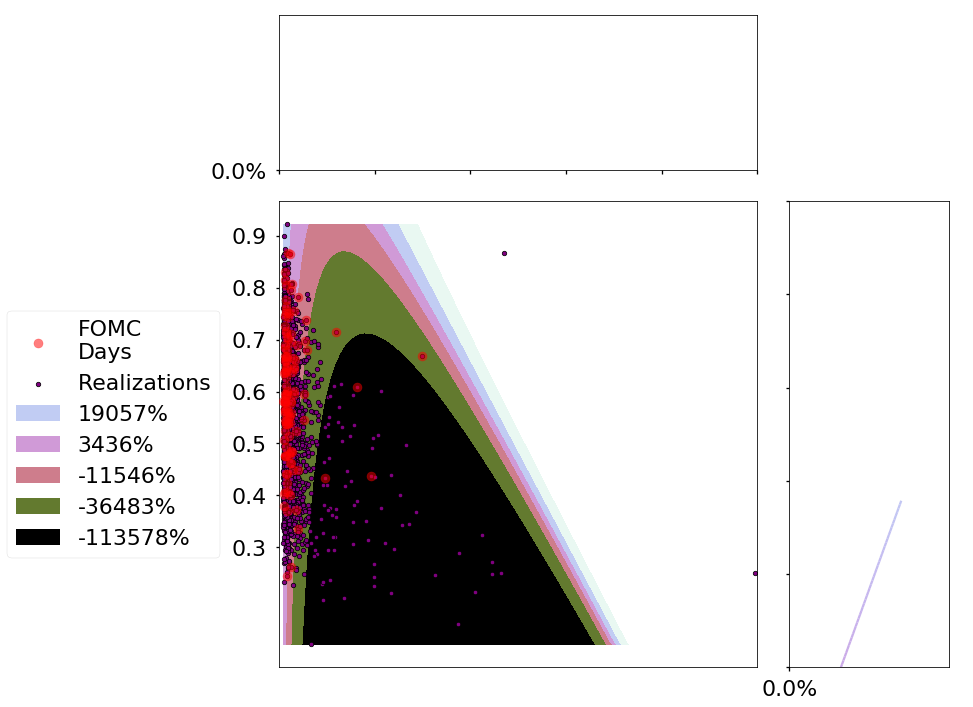

In [87]:
contour_fig, contour_axes = mpl.pyplot.subplots(ncols=2, nrows=2, 
                                                gridspec_kw={'width_ratios':[3,1], 'height_ratios':[1,3],
                                                            'wspace':0.1, 'hspace':0.1})
contour_fig.set_size_inches((12,12))
((log_quad_ax,  hidden_ax), (contour_ax, prop_ax)) = contour_axes
# contour_fig.set_size_inches((10,10))
hidden_ax.set_axis_off()

cs = contour_ax.contourf(X,Y,Z, levels=levels, colors=contour_colors)
contour_proxy = [mpl.pyplot.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0]) for pc in cs.collections]

contour_ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(
    demean_quad(np.log(np.square([0.005, 0.01, 0.025, 0.05, .09])))))
contour_ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, y: '{:.3f}'.format(np.exp(demean_quad(x, True))**.5)))
contour_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(demean_prop(np.arange(.3, .9, .1))))
contour_ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, y: '{:.1f}'.format(demean_prop(x, True))))

contour_ax.scatter(x=announcement_data.log_quad, y=announcement_data.prop, color='red', zorder=10, 
                   alpha=.5,label='FOMC\nDays')


# contour_ax.set_ylim([np.asscalar(contour_plot_data.prop.min()), np.asscalar(contour_plot_data.prop.max())])
# contour_ax.set_xlim([np.asscalar(contour_plot_data.log_quad.min()), np.asscalar(contour_plot_data.log_quad.max())])


prop_ax.set_axis_off()
log_quad_ax.set_axis_off()

# Save the Contour Axis by Itself
contour_ax.legend(contour_proxy[::-1], contour_formatted_labels[::-1],
                  loc='center right', bbox_to_anchor=(-.1, .5))

contour_fig.savefig('../doc/figures/jump_prop_rt_countor_no_realizations.tmp.pdf', transparent=True,
                    frameon=False, bbox_inches='tight', pad_inches=0)

prop_ax.set_axis_on()
log_quad_ax.set_axis_on()

## Add the Prop Axes Values

# log_vol_lines = mpl.collections.LineCollection(lines, colors=log_vol_colors)
prop_ax.add_collection(mpl.collections.LineCollection(prop_lines, colors=prop_colors))

# prop_ax.set_ylim([np.asscalar(prop_xvals.min()), np.asscalar(prop_xvals.max())])
# prop_ax.set_xlim([-.025,.01])
prop_ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())
prop_ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, y: '{:.1f}%'.format(100 * x)))
prop_ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([-.05, -.025, 0]))

## Add the log_quad values

log_quad_ax.add_collection(mpl.collections.LineCollection(log_vol_lines, colors=log_vol_colors))

# log_quad_ax.set_ylim(-.025, .01)
# log_quad_ax.set_xlim([np.asscalar(log_quad_xvals.min()), np.asscalar(log_quad_xvals.max())])
log_quad_ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
log_quad_ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, y: '{:.1f}%'.format(100 * x)))
log_quad_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([-.05, -.025, 0]))

contour_ax.scatter(x=contour_plot_data.log_quad, y=contour_plot_data.prop, facecolor='purple',
                   edgecolor='black',alpha=1,linewidth=.75, s=20, label='Realizations')
handles2, labels2 = contour_ax.get_legend_handles_labels()

contour_ax.legend(list(handles2) + contour_proxy[::-1][2:], 
                  list(labels2) + contour_formatted_labels[::-1][2:], 
                  loc='center right', bbox_to_anchor=(-.1, .5))
contour_fig.savefig('../doc/figures/jump_prop_rt_countor.tmp.pdf', transparent=True, frameon=False,
                    bbox_inches='tight', pad_inches=0)



## Evaluate the Linear Model with IV

In [88]:
from linearmodels import iv

In [89]:
contour_plot_data.head()

fomc_dates  absolute  diffusion    jumps        quad  jump_prop  \
2003-01-03         0.0   -4.8204    -9.5487  -9.8776  1.2261e-04     0.4185   
2003-01-06         0.0   -5.0934   -10.3153 -10.1494  7.2221e-05     0.5414   
2003-01-07         0.0   -4.7491    -9.5571  -9.7226  1.3061e-04     0.4587   
2003-01-08         0.0   -4.9081   -10.1354  -9.6905  1.0152e-04     0.6094   
2003-01-09         0.0   -5.0847   -10.7241  -9.7725  7.9005e-05     0.7214   

            daily_rtn  log_quad    prop  
2003-01-03    -0.1317   10.0408 -0.1459  
2003-01-06     5.4954   10.0408 -0.0231  
2003-01-07    -1.5315   10.0408 -0.1057  
2003-01-08    -3.7850   10.0408  0.0450  
2003-01-09     4.8963   10.0408  0.1570

In [90]:
formula1 = 'daily_rtn ~ 1+ [log_quad + jump_prop ~ fomc_dates + log_quad.shift(1) + log_quad.shift(2)]'
iv.IVGMMCUE.from_formula(formula1, weights=data.quad**(-1), data=contour_plot_data).fit(
    cov_type='kernel')

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/iv/results.py:226: RuntimeWarning: invalid value encountered in sqrt
  std_errors = sqrt(diag(self.cov))
/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -307.19
Estimator:                     IV-GMM   Adj. R-squared:                -307.36
No. Observations:                3676   F-statistic:                   -1.5722
Date:                Thu, Dec 20 2018   P-value (F-stat)                1.0000
Time:                        11:39:08   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept  -1.013e+06  1.971e+05    -5.1395     0.0000  -1.399e+06  -6.266e+05
log_quad    1.009e+05  1.964e+04     5.1368     0.0000   6.238e+04   1.393e+05
jump_prop      261.86                              nan                        
==============================================================================

Endogenous: log_quad, jump_prop
Instruments: fomc_dates, log_quad.shift(1), log_quad.shift(2)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 3674
IVGMMResults, id: 0x7f691f634400

In [91]:
formula2 = 'daily_rtn  ~ 1 + [jump_prop ~ fomc_dates]'
iv.IVGMMCUE.from_formula(formula2,  data=contour_plot_data).fit(cov_type='kernel')

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.9923
Estimator:                     IV-GMM   Adj. R-squared:                -0.9928
No. Observations:                3678   F-statistic:                    11.838
Date:                Thu, Dec 20 2018   P-value (F-stat)                0.0006
Time:                        11:39:08   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -15.694     4.7212    -3.3242     0.0009     -24.948     -6.4407
jump_prop      27.872     8.1011     3.4406     0.0006      11.995      43.750
==============================================================================

Endogenous: jump_prop
Instruments: fomc_dates
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 3676
IVGMMResults, id: 0x7f691f6236a0

In [92]:
formula2 = 'daily_rtn  ~ 1 + [fomc_dates ~ jump_prop]'
iv.IVGMMCUE.from_formula(formula2,  data=contour_plot_data).fit(cov_type='kernel')

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -6.5540
Estimator:                     IV-GMM   Adj. R-squared:                -6.5561
No. Observations:                3678   F-statistic:                    18.960
Date:                Thu, Dec 20 2018   P-value (F-stat)                0.0000
Time:                        11:39:09   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -1.3024     0.2960    -4.3999     0.0000     -1.8826     -0.7223
fomc_dates     42.870     9.8454     4.3543     0.0000      23.574      62.167
==============================================================================

Endogenous: fomc_dates
Instruments: jump_prop
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 3676
IVGMMResults, id: 0x7f692c2cc320